<a href="https://colab.research.google.com/github/blackgreenc/AI/blob/main/index_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install yfinance

In [38]:
import numpy as np
import pandas as pd
import yfinance as yf #야후 파이낸스 데이터

There are252observations in the training data
There are5285observations in the training data


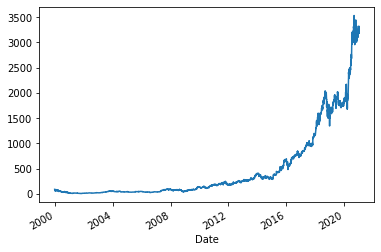

In [39]:
#아마존
AMZN = yf.download('AMZN',
                     start = '2000-01-01',
                     end = '2021-1-05',
                     progress = False)

AMZN_data = AMZN[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
AMZN_data.head(15)

print("There are" + str(AMZN_data[:"2000"].shape[0]) + "observations in the training data")
print("There are" + str(AMZN_data[:"2021"].shape[0]) + "observations in the training data")
AMZN_data['Adj Close'].plot()



In [51]:
# 나스닥 100
NDX  = yf.download('NDX',
                     start = '2006-01-01',
                     end = '2021-1-05',
                     progress = False)

NDX_data = NDX[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
#NDX_data.rename(columns={'Adj Close':'NDX_Adj Close', 'Open':'NDX_Open', 'High':'NDX_High', 'Low':'NDX_Low', 'Close':'NDX_Close', 'Volume':'NDX_Volume' }, inplace=True)


print("There are" + str(all_data[:"2006"].shape[0]) + "observations in the training data")
print("There are" + str(all_data[:"2021"].shape[0]) + "observations in the training data")

#NDX_data['NDX_Adj Close'].plot()
NDX_data.shape
NDX_data.loc[::-1].head(10)

There are251observations in the training data
There are3777observations in the training data


,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2021-01-04,12694.66,12950.22,12950.22,12537.42,12694.66,6546740000
2020-12-31,12888.28,12852.96,12904.09,12804.75,12888.28,4771390000
2020-12-30,12845.36,12900.03,12917.45,12828.79,12845.36,5292210000
2020-12-29,12843.49,12909.86,12925.53,12816.59,12843.49,4680780000
2020-12-28,12838.86,12813.97,12861.91,12747.05,12838.86,5076340000
2020-12-24,12711.01,12668.20,12732.55,12665.80,12711.01,3305950000
2020-12-23,12653.14,12733.75,12737.59,12649.60,12653.14,7028650000
2020-12-22,12717.56,12715.48,12761.23,12606.42,12717.56,5700760000
2020-12-21,12690.26,12575.60,12706.44,12474.03,12690.26,5156470000


In [41]:
print(all_data.sample(n=5))

            WTI_Adj Close  WTI_Open  ...  GOLD_Close  GOLD_Volume
Date                                 ...                         
2012-08-03          14.85     16.33  ...       32.75      8165300
2016-07-26           2.05      2.07  ...       20.45     15632200
2018-10-08           8.43      8.96  ...       11.41     13408900
2018-09-13           6.80      6.89  ...       10.11     12262700
2009-02-10           9.39     12.40  ...       37.13     13318600

[5 rows x 18 columns]


There are251observations in the training data
There are3777observations in the test data


,GOLD_Adj Close,GOLD_Open,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume
Date,,,,,,
2021-01-04,24.00,23.85,24.80,23.62,24.62,41044700
2020-12-31,22.21,23.25,23.27,22.70,22.78,18088000
2020-12-30,22.66,22.97,23.28,22.85,23.24,16046500
2020-12-29,22.33,22.96,23.28,22.75,22.91,14663900
2020-12-28,22.27,23.52,23.54,22.80,22.84,15946700
2020-12-24,22.32,22.80,23.04,22.73,22.90,4920100
2020-12-23,22.26,22.62,23.03,22.56,22.83,11737800
2020-12-22,21.95,23.00,23.05,22.26,22.52,19820200
2020-12-21,22.44,23.25,23.41,22.95,23.02,20688200


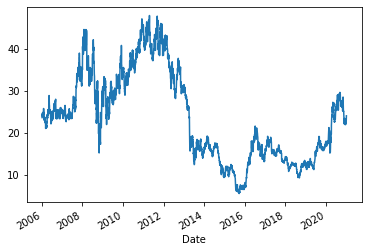

In [42]:
# 금값
GOLD  = yf.download('GOLD',
                     start = '2006-01-01',
                     end = '2021-1-05',
                     progress = False)

GOLD_data = GOLD[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
GOLD_data.rename(columns={'Adj Close':'GOLD_Adj Close', 'Open':'GOLD_Open', 'High':'GOLD_High', 'Low':'GOLD_Low', 'Close':'GOLD_Close', 'Volume':'GOLD_Volume' }, inplace=True)


print("There are" + str(GOLD_data[:"2006"].shape[0]) + "observations in the training data")
print("There are" + str(GOLD_data[:"2021"].shape[0]) + "observations in the test data")

GOLD_data['GOLD_Adj Close'].plot()
GOLD_data.loc[::-1].head(10)

There are251observations in the training data
There are3777observations in the training data


,WTI_Adj Close,WTI_Open,WTI_High,WTI_Low,WTI_Close,WTI_Volume
Date,,,,,,
2021-01-04,2.20,2.21,2.26,2.15,2.20,2512500
2020-12-31,2.17,2.22,2.26,2.15,2.17,2467800
2020-12-30,2.24,2.23,2.27,2.21,2.24,2441100
2020-12-29,2.21,2.27,2.30,2.20,2.21,2749500
2020-12-28,2.25,2.33,2.38,2.24,2.25,2657200
2020-12-24,2.30,2.39,2.40,2.29,2.30,1381500
2020-12-23,2.38,2.26,2.47,2.26,2.38,3636800
2020-12-22,2.24,2.35,2.36,2.23,2.24,3225900
2020-12-21,2.33,2.28,2.40,2.27,2.33,3104200


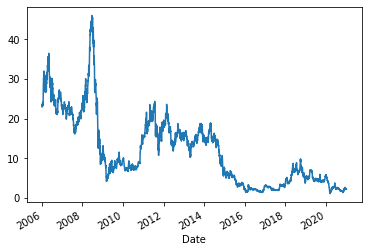

In [43]:
# 기름 
WTI  = yf.download('WTI',
                     start = '2006-01-01',
                     end = '2021-1-05',
                     progress = False)

WTI_data = WTI[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
WTI_data.rename(columns={'Adj Close':'WTI_Adj Close', 'Open':'WTI_Open', 'High':'WTI_High', 'Low':'WTI_Low', 'Close':'WTI_Close', 'Volume':'WTI_Volume' }, inplace=True)


print("There are" + str(WTI_data[:"2006"].shape[0]) + "observations in the training data")
print("There are" + str(WTI_data[:"2021"].shape[0]) + "observations in the training data")

WTI_data['WTI_Adj Close'].plot()
WTI_data.loc[::-1].head(10)

In [44]:
#all_data = pd.concat([WTI_data, NDX_data, GOLD_data], axis=1)
#all_data.head(12)

In [45]:
# all_Adj_data = df.concat([NDX_data['NDX_Adj Close'], GOLD_data['GOLD_Adj Close'],WTI_data['WTI_Adj Close']], axis = 1)
# all_Adj_data.head()

# all_Adj_data.shape

In [46]:
def ts_train_test(all_data, time_steps, for_periods):
    #traing & test set 만들기
    ts_train = all_data[:'2020'].iloc[:, 0:1].values
    ts_test = all_data['2020' : ].iloc[ :, 0 : 1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    #training 데이터의 samples 와 time steps로 원본데이터 슬라이싱하기
    X_train = []
    y_train = []
    y_train_stacked = []

    print(np.shape(ts_train))
    for i in range(time_steps, ts_train_len - 1):
        X_train.append(ts_train[i - time_steps : i, 0])
        y_train.append(ts_train[i : i + for_periods, 0])
    print(np.shape(X_train))
    X_train, y_train = np.array(X_train), np.array(y_train)

    #3차원으로 재구성하기
    #np.reshape(samples, time steps, features)로 만듦
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Preparing to create X_test
    inputs = pd.concat((all_data["Adj Close"][:'2020'], all_data["Adj Close"]['2020':]), axis = 0).values
    inputs = inputs[len(inputs) - len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    print(np.shape(inputs))

    X_test = []
    for i in range(time_steps, ts_test_len+ time_steps- for_periods):
        X_test.append(inputs[i - time_steps :i, 0])
    print(np.shape(X_test))
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))

    return X_train, y_train, X_test

In [53]:
X_train, y_train, X_test = ts_train_test(NDX_data, 5, 2)

# 3차원의 X_train을 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# 3차원의 X_test를 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
# There are ? samples in the training data


print("There are " + str(X_test.shape[0]) + " samples in the test data")
# There are ? samples in the test data


(3776, 1)
(3770, 5)
(259, 1)
(252, 5)
There are 3770 samples in the training data
There are 252 samples in the test data


In [ ]:
print(NDX_data.shape)

In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):
    # import neccesary modul
    from keras.models import Sequential
    from keras.layers import Densa, SimpleRNN, GRU, LSTM_model
    from keras.optimizer import SGD

    # LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50,
                           return_sequences = True,
                           #이거는 바꿔라 데이터에 따라
                           input_shape = (X_train.shape[3],1),
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units = 2))

    # compiling
    my_LSTM_model.compile(optimizer =SGD(lr = 0.01, decay = 1e-7, momentum = 0.9, nesterov = False),
                          loss = 'mean_squared_error') # momentum은 관성을 나타냄
    
    # training data 세트에 피팅하기 (조기 중단은 추가함)
    my_LSTM_model.fit(X_train, y_train, epochs = 50, early_stopping_epochs = 20, batch_size = 150, verbose = 0)

    # X_test를 LSTM model에 넣어서 예측하기
    LSTM_prediction = my_LSTM_model.predict(X_test)

    #스케일러에 예측값 넣어 반환하기
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction


In [ ]:
def actual_pred_plot(preds):
    # Plot the actual vs prediction

    actual_pred = pd.DataFrame(columns = ['NDX_Adj Close', 'prediction'])
    actual_pred['NDX_Adj Close'] = all_data.loc['2006':, 'NDX Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:, 0]

    from keras.metrics import meanSquaredError
    m = meanSquaredError()
    m.update_state(np.array(actual_pred['NDX_Adj Close']), np.array(actual_pred['prediction']))

    return(m.result().numpy(), actual_pred_plot())

In [ ]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)